In [ ]:
pip install deep-pipe

     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for deep-pipe: filename=deep_pipe-0.1.1-py3-none-any.whl size=102401 sha256=2761b8f1c6fa1853be6884effea2a642f747a7ddd211bee55a7fc616d819c360
  Stored in directory: /root/.cache/pip/wheels/e9/d1/b3/9e1a4c95d9c2e162c4954c9088026ef3c0e0d539164e124f58
  Created wheel for pdp: filename=pdp-0.3.0-py3-none-any.whl size=6618 sha256=ed45dbdf974703b041dda1bfb11f2a107d56dbe00363978da59fa90a96eb3b24
  Stored in directory: /root/.cache/pip/wheels/86/3f/21/790268989f0e594527d3b781d80e150499eb918f8c88c1509a
  Created wheel for lazycon: filename=lazycon-0.3.1-py3-none-any.whl size=18969 sha256=39ef05ec56e7a82ab0526d942e82142d3ead91ce45d71ddad547768d6f3d5f31
  Stored in directory: /root/.cache/pip/wheels/aa/2d/3b/3195fbb687e1b108cb48d4057d56fa4602a695dd9518cec27c
  Created wheel for tensorboard-easy: filename=tensorboard_easy-0.2.3-py3-none-any.whl size=16283 sha256=074ef0cc4482c733b6d23de83f516d60727d9c3940872903ad79eeb283873727
 

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms
from torchvision.models.resnet import ResNet, BasicBlock

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time, os, copy
from PIL import Image
import natsort
import cv2
import random 


from PIL import Image
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import cv2
from tqdm import tqdm

import torch
import nibabel as nib
from torch.utils.data import Dataset
from torch.utils.data import random_split
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

from statistics import mean

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Model

In [ ]:
from torch import nn
from dpipe.layers.resblock import ResBlock2d
from dpipe.layers.conv import PreActivation2d


class UNet2D(nn.Module):
    def __init__(self, n_chans_in, n_chans_out, kernel_size=3, padding=1, pooling_size=2, n_filters_init=8,
                 dropout=False, p=0.1):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.pooling_size = pooling_size
        n = n_filters_init
        if dropout:
            dropout_layer = nn.Dropout(p)
        else:
            dropout_layer = nn.Identity()

        self.init_path = nn.Sequential(
            nn.Conv2d(n_chans_in, n, self.kernel_size, padding=self.padding, bias=False),
            nn.ReLU(),
            ResBlock2d(n, n, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n, n, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n, n, kernel_size=self.kernel_size, padding=self.padding)
        )
        self.shortcut0 = nn.Conv2d(n, n, 1)

        self.down1 = nn.Sequential(
            nn.BatchNorm2d(n),
            nn.Conv2d(n, n * 2, kernel_size=pooling_size, stride=pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer,
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding)
        )
        self.shortcut1 = nn.Conv2d(n * 2, n * 2, 1)

        self.down2 = nn.Sequential(
            nn.BatchNorm2d(n * 2),
            nn.Conv2d(n * 2, n * 4, kernel_size=pooling_size, stride=pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer,
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding)
        )
        self.shortcut2 = nn.Conv2d(n * 4, n * 4, 1)

        self.down3 = nn.Sequential(
            nn.BatchNorm2d(n * 4),
            nn.Conv2d(n * 4, n * 8, kernel_size=pooling_size, stride=pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer,
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            dropout_layer
        )

        self.up3 = nn.Sequential(
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            nn.BatchNorm2d(n * 8),
            nn.ConvTranspose2d(n * 8, n * 4, kernel_size=self.pooling_size, stride=self.pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer
        )

        self.up2 = nn.Sequential(
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            nn.BatchNorm2d(n * 4),
            nn.ConvTranspose2d(n * 4, n * 2, kernel_size=self.pooling_size, stride=self.pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer
        )

        self.up1 = nn.Sequential(
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            nn.BatchNorm2d(n * 2),
            nn.ConvTranspose2d(n * 2, n, kernel_size=self.pooling_size, stride=self.pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer
        )

        self.out_path = nn.Sequential(
            ResBlock2d(n, n, kernel_size=1),
            PreActivation2d(n, n_chans_out, kernel_size=1),
            nn.BatchNorm2d(n_chans_out)
        )

    def forward(self, x):
        x0 = self.init_path(x)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)

        x2_up = self.up3(x3)
        x1_up = self.up2(x2_up + self.shortcut2(x2))
        x0_up = self.up1(x1_up + self.shortcut1(x1))
        x_out = self.out_path(x0_up + self.shortcut0(x0))

        return F.sigmoid(x_out)

# Dataset

In [ ]:
class ScanDataset(Dataset):
    def __init__(self, path = '/content/gdrive/MyDrive/GE/', domain = 'ge', ptype = '3'):
      
      original_path = path + domain + ptype + '_original_images.npy'
      mask_path = path + domain + ptype + '_mask_images.npy'

      self.original_images = np.load( original_path )
      self.mask_images = np.load( mask_path )

    def __len__(self):
        return len(self.original_images)

    def __getitem__(self, idx):

        original_batch = torch.from_numpy(self.original_images[idx]).float()
        mask_batch = torch.from_numpy(self.mask_images[idx]).float()

        return original_batch, mask_batch

In [ ]:
def plotting(path, batch_idx, original, mask, pred):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  fig.set_size_inches(6, 8, forward=True)
  fig.set_dpi(120)
  fig.tight_layout()
  ax1.imshow(original[0][0].detach().cpu().numpy(), cmap = 'gray')
  ax2.imshow(mask[0][0].detach().cpu().numpy(), cmap = 'gray')
  ax3.imshow(pred[0][0].detach().cpu().numpy(), cmap = 'gray')
  ax1.set_title('original')
  ax2.set_title('mask')
  ax3.set_title('pred')
  plt.savefig(path + '_' + str(batch_idx))
  plt.pause(0.00001)

In [ ]:
def test(model, data_loader, loss_func, domain, ptype, device ):
    model.eval()

    loss_hist = []  # loss
    BCE_loss_hist = []
    dice_loss_hist = []
        
    with torch.no_grad():

        for batch_idx, data in enumerate(data_loader):

            original = torch.unsqueeze(data[0].float(), axis = 1).to(device)

            mask = torch.unsqueeze(data[1].float(), axis = 1).to(device)

            pred = model(original)

            loss, BCE, dice_loss = loss_func(pred, mask)

            if batch_idx % 10 == 0:
              print( "Test| Batch:",batch_idx,"| Combined Loss:", loss.item(),"| BCE",BCE.item(),"| dice_loss",dice_loss.item() )

            if batch_idx % 80 == 0:

              plotting('/content/gdrive/MyDrive/VMIA_Lab_Data/Plots/Combined_Loss/Test/'+domain+ptype+'/plot_', batch_idx, original, mask, pred)
              
            loss_hist.append(loss.item())
            BCE_loss_hist.append(BCE.item())
            dice_loss_hist.append(dice_loss.item())

    return loss_hist, BCE_loss_hist, dice_loss_hist

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer     
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE, BCE, dice_loss

In [ ]:
model = torch.load('/content/gdrive/MyDrive/VMIA_Lab_Data/GE3/ge3_train70_25epochs_combinedloss.pkl', map_location=torch.device('cpu')).to(device)  #, map_location=torch.device('cpu')
batch_size = 16

# Test on GE test set

## GE 3

In [ ]:
path = '/content/gdrive/MyDrive/GE/'
domain = 'ge'
ptype = '3'

data = ScanDataset(path, domain, ptype)

In [ ]:
print(len(data))

1360


In [ ]:
print(device)
data_loader = torch.utils.data.DataLoader(dataset = data, batch_size = batch_size, shuffle = False ,num_workers = 0)

loss = DiceBCELoss()

cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test| Batch: 0 | Combined Loss: 0.9967939853668213 | BCE 0.00021925616601947695 | dice_loss 0.9965746998786926


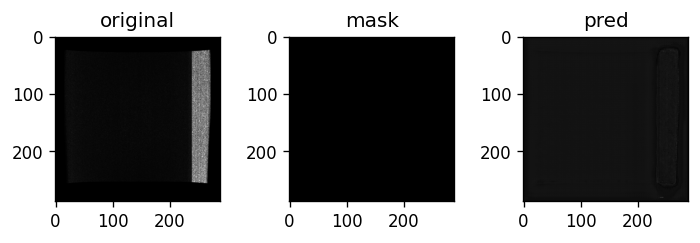

Test| Batch: 10 | Combined Loss: 0.9968053698539734 | BCE 0.0002199526788899675 | dice_loss 0.9965854287147522
Test| Batch: 20 | Combined Loss: 0.03598392754793167 | BCE 0.009757226333022118 | dice_loss 0.026226699352264404
Test| Batch: 30 | Combined Loss: 0.015991657972335815 | BCE 0.0069282944314181805 | dice_loss 0.009063363075256348
Test| Batch: 40 | Combined Loss: 0.016978789120912552 | BCE 0.007490743882954121 | dice_loss 0.009488046169281006
Test| Batch: 50 | Combined Loss: 0.0398719385266304 | BCE 0.009600406512618065 | dice_loss 0.030271530151367188
Test| Batch: 60 | Combined Loss: 0.9968070387840271 | BCE 0.0002200496819568798 | dice_loss 0.9965869784355164
Test| Batch: 70 | Combined Loss: 0.07088171690702438 | BCE 0.0034911560360342264 | dice_loss 0.0673905611038208
Test| Batch: 80 | Combined Loss: 0.019308043643832207 | BCE 0.008745087310671806 | dice_loss 0.0105629563331604


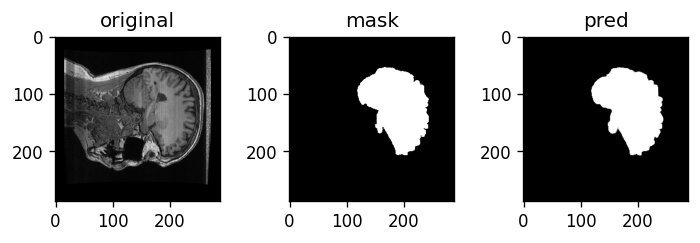

Average combined loss  --> 0.26976380111540066
Average BCE loss  --> 0.006374158026301302
Average dice loss  --> 0.2633896413971396


In [ ]:
loss_hist, BCE_loss_hist, dice_loss_hist = test(model, data_loader, loss, domain, ptype, device)
print("Average combined loss  -->", mean(loss_hist))
print("Average BCE loss  -->", mean(BCE_loss_hist))
print("Average dice loss  -->", mean(dice_loss_hist))

## GE 15

11710
cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test| Batch: 0 | Combined Loss: 0.9968346357345581 | BCE 0.00022174442710820585 | dice_loss 0.9966129064559937


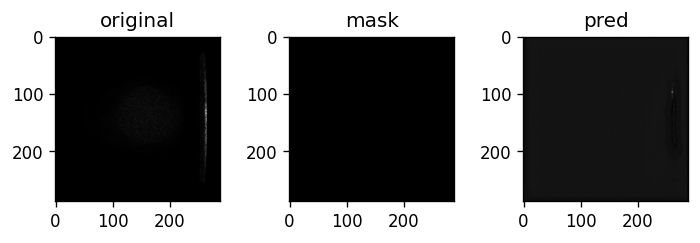

Test| Batch: 10 | Combined Loss: 0.2204541265964508 | BCE 0.039587169885635376 | dice_loss 0.18086695671081543
Test| Batch: 20 | Combined Loss: 0.2517993450164795 | BCE 0.128599151968956 | dice_loss 0.1232001781463623
Test| Batch: 30 | Combined Loss: 0.038965728133916855 | BCE 0.017627324908971786 | dice_loss 0.02133840322494507
Test| Batch: 40 | Combined Loss: 0.049232155084609985 | BCE 0.025435417890548706 | dice_loss 0.02379673719406128
Test| Batch: 50 | Combined Loss: 0.1701064109802246 | BCE 0.039853159338235855 | dice_loss 0.13025325536727905
Test| Batch: 60 | Combined Loss: 0.9812870621681213 | BCE 0.018283940851688385 | dice_loss 0.9630030989646912
Test| Batch: 70 | Combined Loss: 0.04332617670297623 | BCE 0.017583290114998817 | dice_loss 0.02574288845062256
Test| Batch: 80 | Combined Loss: 0.3188709616661072 | BCE 0.18197371065616608 | dice_loss 0.1368972659111023


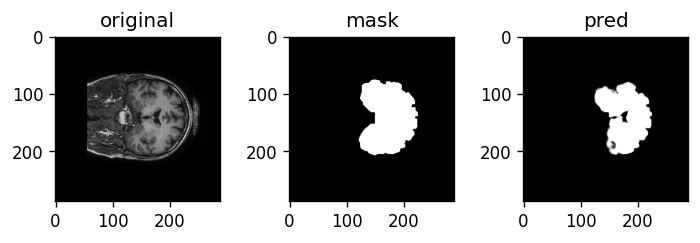

Test| Batch: 90 | Combined Loss: 0.20995335280895233 | BCE 0.1328936070203781 | dice_loss 0.07705974578857422
Test| Batch: 100 | Combined Loss: 0.07843659818172455 | BCE 0.04117707908153534 | dice_loss 0.03725951910018921
Test| Batch: 110 | Combined Loss: 0.16155517101287842 | BCE 0.017034895718097687 | dice_loss 0.14452028274536133
Test| Batch: 120 | Combined Loss: 0.6600816249847412 | BCE 0.07578707486391068 | dice_loss 0.5842945575714111
Test| Batch: 130 | Combined Loss: 0.07159741222858429 | BCE 0.02464498206973076 | dice_loss 0.04695242643356323
Test| Batch: 140 | Combined Loss: 0.14162717759609222 | BCE 0.09017013013362885 | dice_loss 0.05145704746246338
Test| Batch: 150 | Combined Loss: 0.4878905117511749 | BCE 0.3072492182254791 | dice_loss 0.1806412935256958
Test| Batch: 160 | Combined Loss: 0.1639019250869751 | BCE 0.03991658240556717 | dice_loss 0.12398535013198853


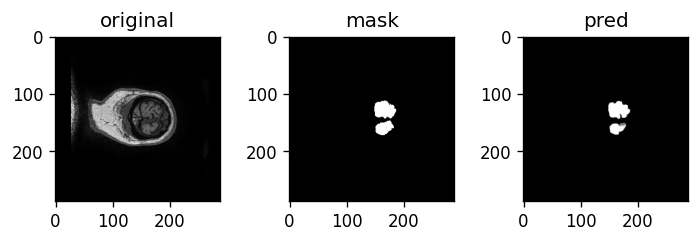

Test| Batch: 170 | Combined Loss: 1.0224621295928955 | BCE 0.027643386274576187 | dice_loss 0.9948186874389648
Test| Batch: 180 | Combined Loss: 0.12326158583164215 | BCE 0.043470460921525955 | dice_loss 0.0797911286354065
Test| Batch: 190 | Combined Loss: 0.32285428047180176 | BCE 0.1658245325088501 | dice_loss 0.15702974796295166
Test| Batch: 200 | Combined Loss: 0.11907944828271866 | BCE 0.06746874004602432 | dice_loss 0.051610708236694336
Test| Batch: 210 | Combined Loss: 0.45686841011047363 | BCE 0.29119306802749634 | dice_loss 0.1656753420829773
Test| Batch: 220 | Combined Loss: 0.11430478096008301 | BCE 0.0367509163916111 | dice_loss 0.07755386829376221
Test| Batch: 230 | Combined Loss: 1.0186694860458374 | BCE 0.019099337980151176 | dice_loss 0.9995701909065247
Test| Batch: 240 | Combined Loss: 0.06908075511455536 | BCE 0.01722220703959465 | dice_loss 0.05185854434967041


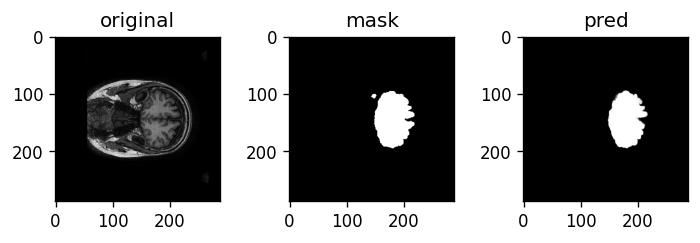

Test| Batch: 250 | Combined Loss: 0.2784688472747803 | BCE 0.14216089248657227 | dice_loss 0.136307954788208
Test| Batch: 260 | Combined Loss: 0.2079240381717682 | BCE 0.11709312349557877 | dice_loss 0.09083092212677002
Test| Batch: 270 | Combined Loss: 0.6715406179428101 | BCE 0.4249745011329651 | dice_loss 0.24656611680984497
Test| Batch: 280 | Combined Loss: 0.1114269495010376 | BCE 0.04811996594071388 | dice_loss 0.06330698728561401
Test| Batch: 290 | Combined Loss: 0.9968032836914062 | BCE 0.0002198231959482655 | dice_loss 0.9965834617614746
Test| Batch: 300 | Combined Loss: 0.10764253884553909 | BCE 0.021586664021015167 | dice_loss 0.08605587482452393
Test| Batch: 310 | Combined Loss: 0.2794815003871918 | BCE 0.14700570702552795 | dice_loss 0.13247579336166382
Test| Batch: 320 | Combined Loss: 0.4096967875957489 | BCE 0.264169305562973 | dice_loss 0.14552748203277588


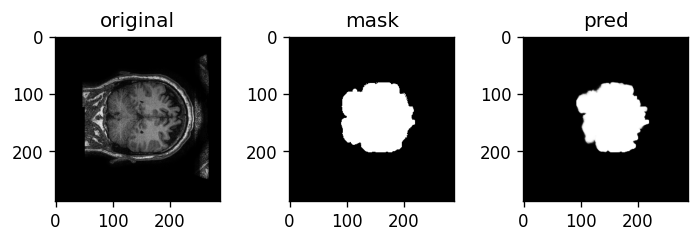

Test| Batch: 330 | Combined Loss: 0.23304036259651184 | BCE 0.10684940218925476 | dice_loss 0.12619096040725708
Test| Batch: 340 | Combined Loss: 0.9969346523284912 | BCE 0.0002980509598273784 | dice_loss 0.9966366291046143
Test| Batch: 350 | Combined Loss: 0.08122308552265167 | BCE 0.01533456053584814 | dice_loss 0.06588852405548096
Test| Batch: 360 | Combined Loss: 0.2601843476295471 | BCE 0.14015276730060577 | dice_loss 0.12003159523010254
Test| Batch: 370 | Combined Loss: 0.05433706194162369 | BCE 0.02817068062722683 | dice_loss 0.02616637945175171
Test| Batch: 380 | Combined Loss: 0.246494323015213 | BCE 0.14328047633171082 | dice_loss 0.1032138466835022
Test| Batch: 390 | Combined Loss: 0.07564941048622131 | BCE 0.01926824450492859 | dice_loss 0.056381165981292725
Test| Batch: 400 | Combined Loss: 0.5080798268318176 | BCE 0.047903597354888916 | dice_loss 0.4601762294769287


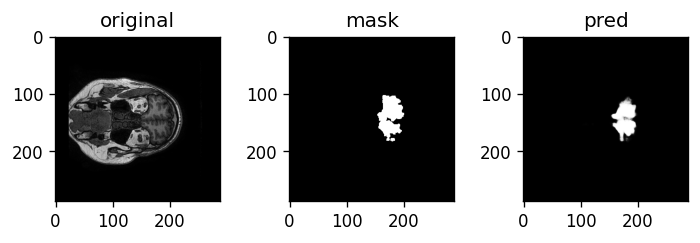

Test| Batch: 410 | Combined Loss: 0.054129697382450104 | BCE 0.013400712050497532 | dice_loss 0.040728986263275146
Test| Batch: 420 | Combined Loss: 0.2512739896774292 | BCE 0.1407756209373474 | dice_loss 0.11049836874008179
Test| Batch: 430 | Combined Loss: 0.78189617395401 | BCE 0.5201868414878845 | dice_loss 0.2617093324661255
Test| Batch: 440 | Combined Loss: 0.14904490113258362 | BCE 0.06377354264259338 | dice_loss 0.08527135848999023
Test| Batch: 450 | Combined Loss: 0.9968030452728271 | BCE 0.0002198091387981549 | dice_loss 0.9965832233428955
Test| Batch: 460 | Combined Loss: 0.1454462707042694 | BCE 0.032713256776332855 | dice_loss 0.11273300647735596
Test| Batch: 470 | Combined Loss: 0.2447994500398636 | BCE 0.12595142424106598 | dice_loss 0.11884802579879761
Test| Batch: 480 | Combined Loss: 0.14562782645225525 | BCE 0.08948829025030136 | dice_loss 0.05613952875137329


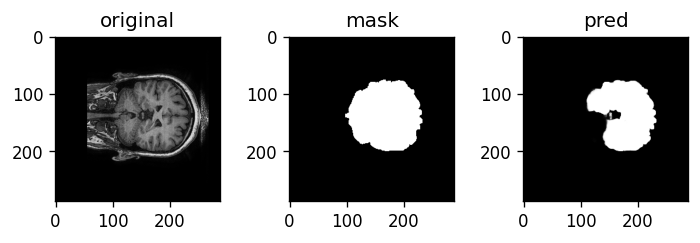

Test| Batch: 490 | Combined Loss: 0.040252745151519775 | BCE 0.021228192374110222 | dice_loss 0.019024550914764404
Test| Batch: 500 | Combined Loss: 0.13134820759296417 | BCE 0.025365959852933884 | dice_loss 0.10598224401473999
Test| Batch: 510 | Combined Loss: 0.12251415848731995 | BCE 0.01910194382071495 | dice_loss 0.1034122109413147
Test| Batch: 520 | Combined Loss: 0.09788665175437927 | BCE 0.030209871008992195 | dice_loss 0.06767678260803223
Test| Batch: 530 | Combined Loss: 0.10247154533863068 | BCE 0.057829033583402634 | dice_loss 0.044642508029937744
Test| Batch: 540 | Combined Loss: 0.7613559365272522 | BCE 0.5078896284103394 | dice_loss 0.25346630811691284
Test| Batch: 550 | Combined Loss: 0.12388860434293747 | BCE 0.04158394783735275 | dice_loss 0.08230465650558472
Test| Batch: 560 | Combined Loss: 0.9968138933181763 | BCE 0.00022046802041586488 | dice_loss 0.9965934157371521


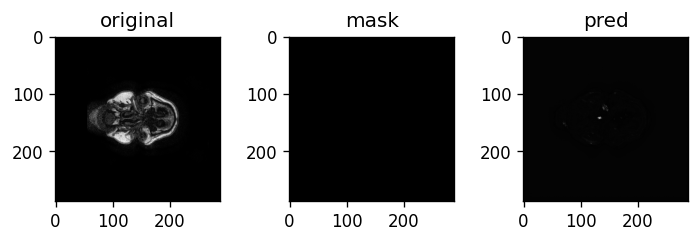

Test| Batch: 570 | Combined Loss: 0.20564281940460205 | BCE 0.043046534061431885 | dice_loss 0.16259628534317017
Test| Batch: 580 | Combined Loss: 0.41252976655960083 | BCE 0.24311824142932892 | dice_loss 0.1694115400314331
Test| Batch: 590 | Combined Loss: 0.22476379573345184 | BCE 0.13311289250850677 | dice_loss 0.09165090322494507
Test| Batch: 600 | Combined Loss: 0.06161728501319885 | BCE 0.02725037932395935 | dice_loss 0.0343669056892395
Test| Batch: 610 | Combined Loss: 0.14881010353565216 | BCE 0.007859130389988422 | dice_loss 0.1409509778022766
Test| Batch: 620 | Combined Loss: 0.8689327239990234 | BCE 0.16169299185276031 | dice_loss 0.7072397470474243
Test| Batch: 630 | Combined Loss: 0.23192521929740906 | BCE 0.12799671292304993 | dice_loss 0.10392850637435913
Test| Batch: 640 | Combined Loss: 0.0807875320315361 | BCE 0.043991439044475555 | dice_loss 0.03679609298706055


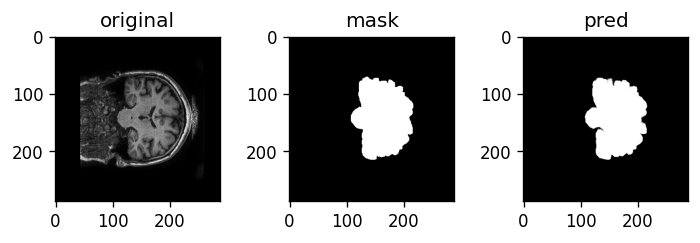

Test| Batch: 650 | Combined Loss: 0.027820002287626266 | BCE 0.01231909915804863 | dice_loss 0.015500903129577637
Test| Batch: 660 | Combined Loss: 0.14754098653793335 | BCE 0.04610193520784378 | dice_loss 0.10143905878067017
Test| Batch: 670 | Combined Loss: 0.6429433822631836 | BCE 0.06492036581039429 | dice_loss 0.5780230164527893
Test| Batch: 680 | Combined Loss: 0.06493360549211502 | BCE 0.018668239936232567 | dice_loss 0.046265363693237305
Test| Batch: 690 | Combined Loss: 0.1348230391740799 | BCE 0.07833905518054962 | dice_loss 0.05648398399353027
Test| Batch: 700 | Combined Loss: 0.41242730617523193 | BCE 0.25460636615753174 | dice_loss 0.1578209400177002
Test| Batch: 710 | Combined Loss: 0.04577381908893585 | BCE 0.01984466426074505 | dice_loss 0.025929152965545654
Test| Batch: 720 | Combined Loss: 0.2212291955947876 | BCE 0.026625271886587143 | dice_loss 0.19460391998291016


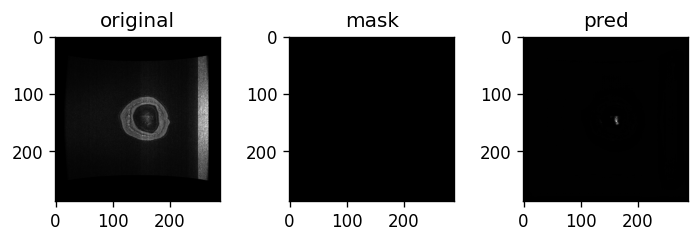

Test| Batch: 730 | Combined Loss: 0.08969234675168991 | BCE 0.016212930902838707 | dice_loss 0.07347941398620605
Average combined loss  --> 0.31214371526898826
Average BCE loss  --> 0.08507740039603363
Average dice loss  --> 0.22706631469270572


In [ ]:
path = '/content/gdrive/MyDrive/GE/'
domain = 'ge'
ptype = '15'

data = ScanDataset(path, domain, ptype)

print('len:',len(data))

print('dev:',device)

data_loader = torch.utils.data.DataLoader(dataset = data, batch_size = batch_size, shuffle = False ,num_workers = 0)
loss = DiceBCELoss()

loss_hist, BCE_loss_hist, dice_loss_hist = test(model, data_loader, loss, domain, ptype, device)
print("Average combined loss  -->", mean(loss_hist))
print("Average BCE loss  -->", mean(BCE_loss_hist))
print("Average dice loss  -->", mean(dice_loss_hist))

# Test on Philips

## Philips 3

len: 10800
dev: cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test| Batch: 0 | Combined Loss: 0.9968201518058777 | BCE 0.0002208494406659156 | dice_loss 0.9965993165969849


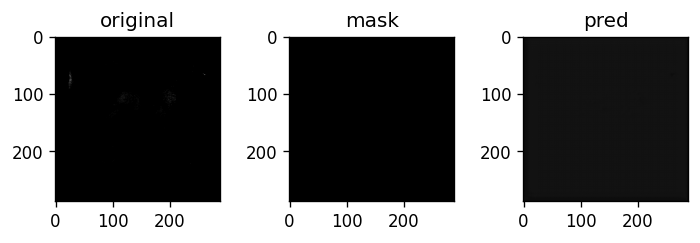

Test| Batch: 10 | Combined Loss: 0.9968177080154419 | BCE 0.00022070627892389894 | dice_loss 0.9965969920158386
Test| Batch: 20 | Combined Loss: 0.0698271244764328 | BCE 0.006516444031149149 | dice_loss 0.06331068277359009
Test| Batch: 30 | Combined Loss: 0.04953568056225777 | BCE 0.02053283527493477 | dice_loss 0.029002845287322998
Test| Batch: 40 | Combined Loss: 0.03797106444835663 | BCE 0.01959310658276081 | dice_loss 0.018377959728240967
Test| Batch: 50 | Combined Loss: 0.19807446002960205 | BCE 0.11255217343568802 | dice_loss 0.08552229404449463
Test| Batch: 60 | Combined Loss: 0.06907781213521957 | BCE 0.0368477925658226 | dice_loss 0.03223001956939697
Test| Batch: 70 | Combined Loss: 0.03716576099395752 | BCE 0.013751863501966 | dice_loss 0.023413896560668945
Test| Batch: 80 | Combined Loss: 0.06678813695907593 | BCE 0.0075305067002773285 | dice_loss 0.0592576265335083


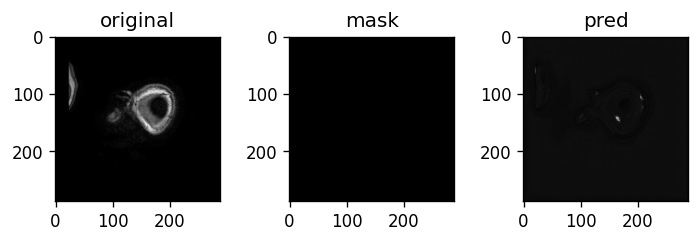

Test| Batch: 90 | Combined Loss: 0.9967923760414124 | BCE 0.00021916069090366364 | dice_loss 0.9965732097625732
Test| Batch: 100 | Combined Loss: 0.9967997074127197 | BCE 0.00021960448066238314 | dice_loss 0.9965801239013672
Test| Batch: 110 | Combined Loss: 0.043625205755233765 | BCE 0.006791442167013884 | dice_loss 0.036833763122558594
Test| Batch: 120 | Combined Loss: 0.23551017045974731 | BCE 0.11595601588487625 | dice_loss 0.11955416202545166
Test| Batch: 130 | Combined Loss: 0.038175247609615326 | BCE 0.01905967853963375 | dice_loss 0.019115567207336426
Test| Batch: 140 | Combined Loss: 0.48471778631210327 | BCE 0.2952563762664795 | dice_loss 0.18946141004562378
Test| Batch: 150 | Combined Loss: 0.03407593071460724 | BCE 0.017994778230786324 | dice_loss 0.016081154346466064
Test| Batch: 160 | Combined Loss: 0.03774470090866089 | BCE 0.012193559668958187 | dice_loss 0.025551140308380127


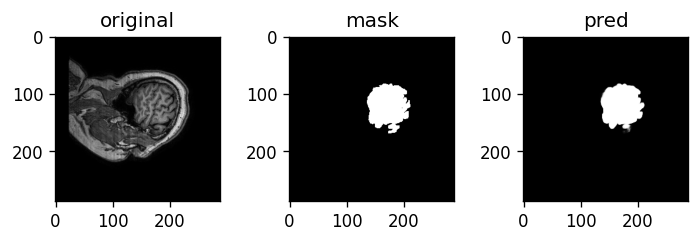

Test| Batch: 170 | Combined Loss: 0.062014706432819366 | BCE 0.014689093455672264 | dice_loss 0.04732561111450195
Test| Batch: 180 | Combined Loss: 0.9968065023422241 | BCE 0.0002200184972025454 | dice_loss 0.9965865015983582
Test| Batch: 190 | Combined Loss: 0.9968228936195374 | BCE 0.00022101684589870274 | dice_loss 0.9966018795967102
Test| Batch: 200 | Combined Loss: 0.051479630172252655 | BCE 0.014526478946208954 | dice_loss 0.0369531512260437
Test| Batch: 210 | Combined Loss: 0.030455991625785828 | BCE 0.012538895010948181 | dice_loss 0.017917096614837646
Test| Batch: 220 | Combined Loss: 0.08186043798923492 | BCE 0.04306354001164436 | dice_loss 0.03879690170288086
Test| Batch: 230 | Combined Loss: 0.576174795627594 | BCE 0.36082011461257935 | dice_loss 0.21535468101501465
Test| Batch: 240 | Combined Loss: 0.0316581167280674 | BCE 0.015822116285562515 | dice_loss 0.015836000442504883


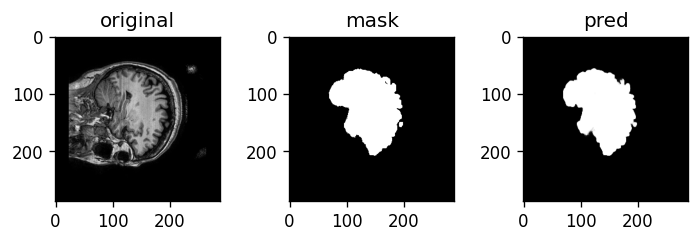

Test| Batch: 250 | Combined Loss: 0.035112712532281876 | BCE 0.014436815865337849 | dice_loss 0.0206758975982666
Test| Batch: 260 | Combined Loss: 0.09330125898122787 | BCE 0.011727476492524147 | dice_loss 0.08157378435134888
Test| Batch: 270 | Combined Loss: 0.9967983961105347 | BCE 0.0002195250999648124 | dice_loss 0.9965788722038269
Test| Batch: 280 | Combined Loss: 0.9971477389335632 | BCE 0.0002525842282921076 | dice_loss 0.9968951344490051
Test| Batch: 290 | Combined Loss: 0.17975254356861115 | BCE 0.03656287118792534 | dice_loss 0.1431896686553955
Test| Batch: 300 | Combined Loss: 0.03130181133747101 | BCE 0.012990489602088928 | dice_loss 0.01831132173538208
Test| Batch: 310 | Combined Loss: 0.04228398948907852 | BCE 0.02164093591272831 | dice_loss 0.02064305543899536
Test| Batch: 320 | Combined Loss: 0.2763810455799103 | BCE 0.1648554503917694 | dice_loss 0.11152559518814087


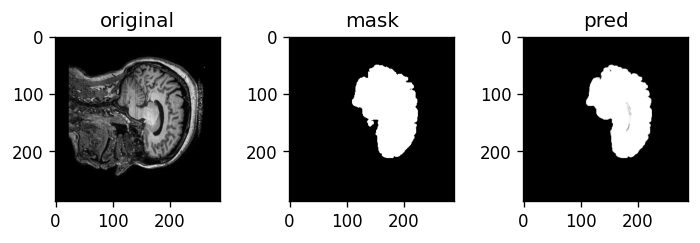

Test| Batch: 330 | Combined Loss: 0.033531226217746735 | BCE 0.01492641307413578 | dice_loss 0.018604815006256104
Test| Batch: 340 | Combined Loss: 0.023072335869073868 | BCE 0.009869609959423542 | dice_loss 0.0132027268409729
Test| Batch: 350 | Combined Loss: 0.1103634238243103 | BCE 0.0105627765879035 | dice_loss 0.09980064630508423
Test| Batch: 360 | Combined Loss: 0.9968088269233704 | BCE 0.0002201573661295697 | dice_loss 0.9965886473655701
Test| Batch: 370 | Combined Loss: 0.9967880845069885 | BCE 0.0002189010992879048 | dice_loss 0.9965691566467285
Test| Batch: 380 | Combined Loss: 0.06178443133831024 | BCE 0.01895950734615326 | dice_loss 0.04282492399215698
Test| Batch: 390 | Combined Loss: 0.032697342336177826 | BCE 0.01413031853735447 | dice_loss 0.018567025661468506
Test| Batch: 400 | Combined Loss: 0.052626270800828934 | BCE 0.02520420029759407 | dice_loss 0.027422070503234863


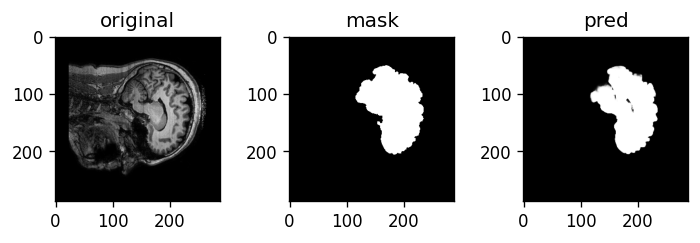

Test| Batch: 410 | Combined Loss: 0.2251332551240921 | BCE 0.1409677416086197 | dice_loss 0.08416551351547241
Test| Batch: 420 | Combined Loss: 0.03601422160863876 | BCE 0.016517065465450287 | dice_loss 0.019497156143188477
Test| Batch: 430 | Combined Loss: 0.0749271810054779 | BCE 0.032912224531173706 | dice_loss 0.0420149564743042
Test| Batch: 440 | Combined Loss: 0.06071140617132187 | BCE 0.00865402165800333 | dice_loss 0.05205738544464111
Test| Batch: 450 | Combined Loss: 0.996811032295227 | BCE 0.00022029316460248083 | dice_loss 0.9965907335281372
Test| Batch: 460 | Combined Loss: 0.9967985153198242 | BCE 0.000219532594201155 | dice_loss 0.9965789914131165
Test| Batch: 470 | Combined Loss: 0.04791584983468056 | BCE 0.011953148990869522 | dice_loss 0.035962700843811035
Test| Batch: 480 | Combined Loss: 0.037472739815711975 | BCE 0.020634127780795097 | dice_loss 0.01683861017227173


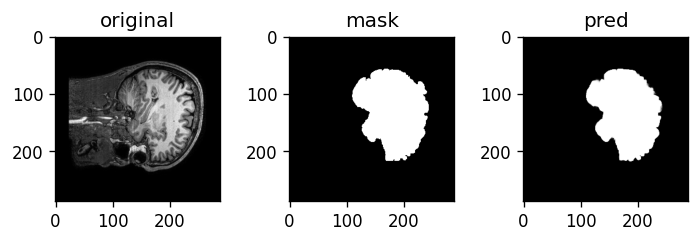

Test| Batch: 490 | Combined Loss: 0.05579380691051483 | BCE 0.0314287394285202 | dice_loss 0.02436506748199463
Test| Batch: 500 | Combined Loss: 0.36505126953125 | BCE 0.24131447076797485 | dice_loss 0.12373679876327515
Test| Batch: 510 | Combined Loss: 0.05262333154678345 | BCE 0.027979910373687744 | dice_loss 0.024643421173095703
Test| Batch: 520 | Combined Loss: 0.031188253313302994 | BCE 0.012698535807430744 | dice_loss 0.018489718437194824
Test| Batch: 530 | Combined Loss: 0.038030050694942474 | BCE 0.005686602555215359 | dice_loss 0.03234344720840454
Test| Batch: 540 | Combined Loss: 0.996818482875824 | BCE 0.00022074667504057288 | dice_loss 0.9965977072715759
Test| Batch: 550 | Combined Loss: 0.9967989325523376 | BCE 0.00021955683769192547 | dice_loss 0.9965793490409851
Test| Batch: 560 | Combined Loss: 0.049907710403203964 | BCE 0.011137689463794231 | dice_loss 0.03877002000808716


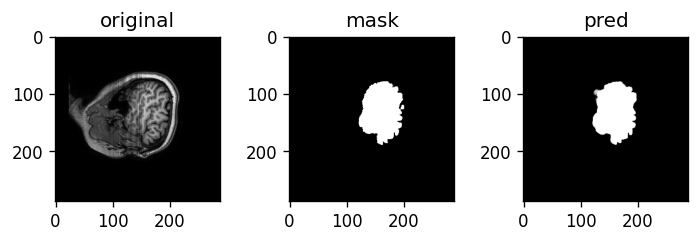

Test| Batch: 570 | Combined Loss: 0.03179480880498886 | BCE 0.012535118497908115 | dice_loss 0.01925969123840332
Test| Batch: 580 | Combined Loss: 0.1191587895154953 | BCE 0.07219885289669037 | dice_loss 0.04695993661880493
Test| Batch: 590 | Combined Loss: 0.7228515148162842 | BCE 0.45153120160102844 | dice_loss 0.2713203430175781
Test| Batch: 600 | Combined Loss: 0.07933065295219421 | BCE 0.04475059732794762 | dice_loss 0.0345800518989563
Test| Batch: 610 | Combined Loss: 0.14184455573558807 | BCE 0.06888101994991302 | dice_loss 0.07296353578567505
Test| Batch: 620 | Combined Loss: 0.07436129450798035 | BCE 0.013053150847554207 | dice_loss 0.06130814552307129
Test| Batch: 630 | Combined Loss: 0.9968130588531494 | BCE 0.0002204157499363646 | dice_loss 0.99659264087677
Test| Batch: 640 | Combined Loss: 0.4512317180633545 | BCE 0.0004550168523564935 | dice_loss 0.45077669620513916


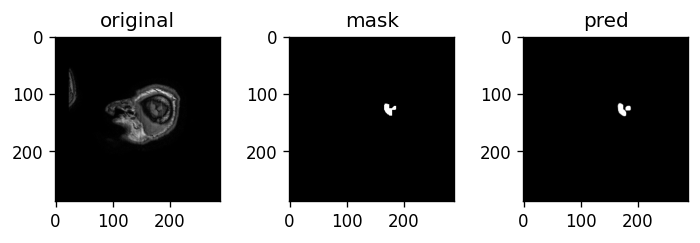

Test| Batch: 650 | Combined Loss: 0.04247011989355087 | BCE 0.008639119565486908 | dice_loss 0.033831000328063965
Test| Batch: 660 | Combined Loss: 0.06355494260787964 | BCE 0.03219145908951759 | dice_loss 0.031363487243652344
Test| Batch: 670 | Combined Loss: 0.06688348948955536 | BCE 0.038992270827293396 | dice_loss 0.027891218662261963
Average combined loss  --> 0.2760988141927454
Average BCE loss  --> 0.04092286222560452
Average dice loss  --> 0.2351759515868293


In [ ]:
path = '/content/gdrive/MyDrive/Philips/'
domain = 'philips'
ptype = '3'

data = ScanDataset(path, domain, ptype)

print('len:',len(data))

print('dev:',device)

data_loader = torch.utils.data.DataLoader(dataset = data, batch_size = batch_size, shuffle = False ,num_workers = 0)
loss = DiceBCELoss()

loss_hist, BCE_loss_hist, dice_loss_hist = test(model, data_loader, loss, domain, ptype, device)
print("Average combined loss  -->", mean(loss_hist))
print("Average BCE loss  -->", mean(BCE_loss_hist))
print("Average dice loss  -->", mean(dice_loss_hist))

##  Philips 15

len: 9201
dev: cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test| Batch: 0 | Combined Loss: 0.9971615076065063 | BCE 0.0002527385950088501 | dice_loss 0.9969087839126587


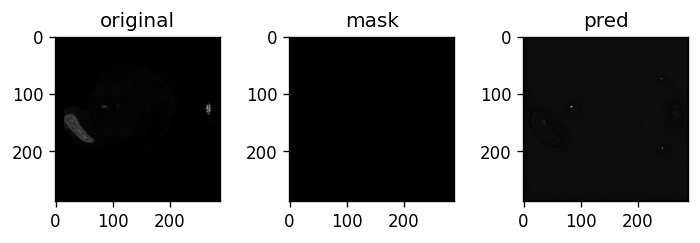

Test| Batch: 10 | Combined Loss: 0.9968478679656982 | BCE 0.00022257202363107353 | dice_loss 0.9966253042221069
Test| Batch: 20 | Combined Loss: 0.1994422972202301 | BCE 0.0012131603434681892 | dice_loss 0.1982291340827942
Test| Batch: 30 | Combined Loss: 0.05844437703490257 | BCE 0.009000475518405437 | dice_loss 0.04944390058517456
Test| Batch: 40 | Combined Loss: 0.10355667024850845 | BCE 0.0023381481878459454 | dice_loss 0.10121852159500122
Test| Batch: 50 | Combined Loss: 0.05135468393564224 | BCE 0.004077472258359194 | dice_loss 0.047277212142944336
Test| Batch: 60 | Combined Loss: 0.0520472377538681 | BCE 0.011628671549260616 | dice_loss 0.04041856527328491
Test| Batch: 70 | Combined Loss: 0.07744592428207397 | BCE 0.002826395910233259 | dice_loss 0.07461953163146973
Test| Batch: 80 | Combined Loss: 0.24513199925422668 | BCE 0.14794036746025085 | dice_loss 0.09719163179397583


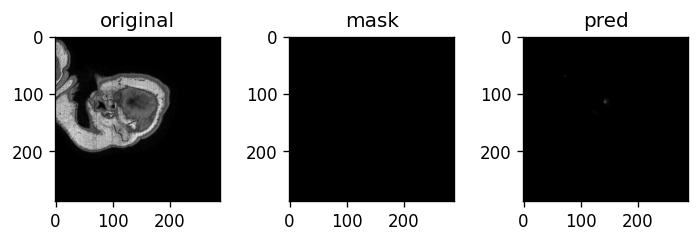

Test| Batch: 90 | Combined Loss: 0.10057449340820312 | BCE 0.025106966495513916 | dice_loss 0.07546752691268921
Test| Batch: 100 | Combined Loss: 0.037631772458553314 | BCE 0.012533032335340977 | dice_loss 0.025098741054534912
Test| Batch: 110 | Combined Loss: 0.021379321813583374 | BCE 0.009847193956375122 | dice_loss 0.011532127857208252
Test| Batch: 120 | Combined Loss: 0.025637395679950714 | BCE 0.012421554885804653 | dice_loss 0.013215839862823486
Test| Batch: 130 | Combined Loss: 0.018330339342355728 | BCE 0.008821610361337662 | dice_loss 0.009508728981018066
Test| Batch: 140 | Combined Loss: 0.025275610387325287 | BCE 0.014704191125929356 | dice_loss 0.010571420192718506
Test| Batch: 150 | Combined Loss: 0.18073388934135437 | BCE 0.12211634963750839 | dice_loss 0.05861753225326538
Test| Batch: 160 | Combined Loss: 0.13537713885307312 | BCE 0.08935912698507309 | dice_loss 0.046018004417419434


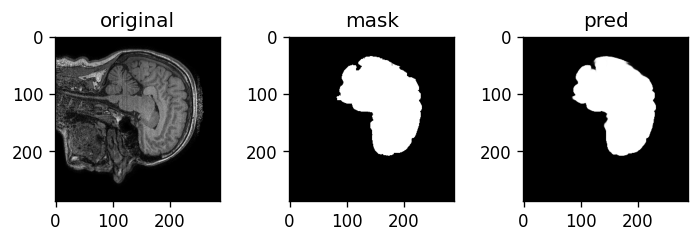

Test| Batch: 170 | Combined Loss: 0.025640398263931274 | BCE 0.01354107353836298 | dice_loss 0.01209932565689087
Test| Batch: 180 | Combined Loss: 0.01857461780309677 | BCE 0.009550116956233978 | dice_loss 0.009024500846862793
Test| Batch: 190 | Combined Loss: 0.01737409457564354 | BCE 0.008466358296573162 | dice_loss 0.008907735347747803
Test| Batch: 200 | Combined Loss: 0.021058473736047745 | BCE 0.01124695222824812 | dice_loss 0.00981152057647705
Test| Batch: 210 | Combined Loss: 0.02312002331018448 | BCE 0.012362875044345856 | dice_loss 0.010757148265838623
Test| Batch: 220 | Combined Loss: 0.02275089919567108 | BCE 0.012889488600194454 | dice_loss 0.009861409664154053
Test| Batch: 230 | Combined Loss: 0.022119535133242607 | BCE 0.010864747688174248 | dice_loss 0.01125478744506836
Test| Batch: 240 | Combined Loss: 0.020088203251361847 | BCE 0.010885723866522312 | dice_loss 0.00920248031616211


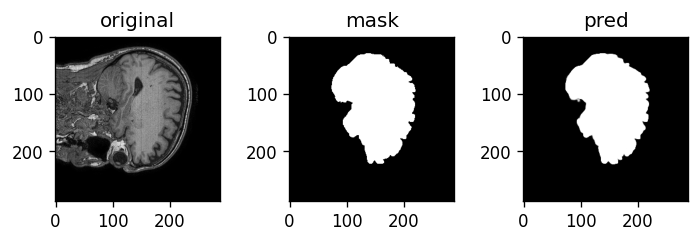

Test| Batch: 250 | Combined Loss: 0.030150635167956352 | BCE 0.01643548719584942 | dice_loss 0.013715147972106934
Test| Batch: 260 | Combined Loss: 0.023440374061465263 | BCE 0.012995434924960136 | dice_loss 0.010444939136505127
Test| Batch: 270 | Combined Loss: 0.021353308111429214 | BCE 0.010784689337015152 | dice_loss 0.010568618774414062
Test| Batch: 280 | Combined Loss: 0.022491570562124252 | BCE 0.011527950875461102 | dice_loss 0.010963618755340576
Test| Batch: 290 | Combined Loss: 0.028473569080233574 | BCE 0.011596454307436943 | dice_loss 0.01687711477279663
Test| Batch: 300 | Combined Loss: 0.04324907809495926 | BCE 0.011964807286858559 | dice_loss 0.03128427267074585
Test| Batch: 310 | Combined Loss: 0.03566877171397209 | BCE 0.005307476501911879 | dice_loss 0.030361294746398926
Test| Batch: 320 | Combined Loss: 0.24974766373634338 | BCE 0.041479434818029404 | dice_loss 0.20826822519302368


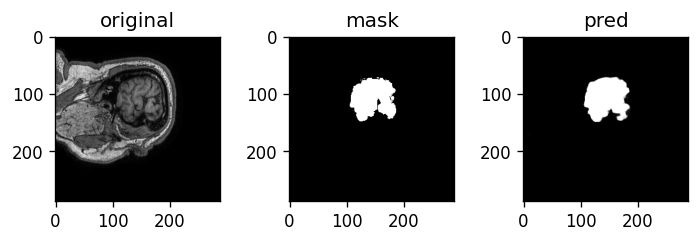

Test| Batch: 330 | Combined Loss: 0.04503919184207916 | BCE 0.006298975553363562 | dice_loss 0.03874021768569946
Test| Batch: 340 | Combined Loss: 0.8364803791046143 | BCE 0.0002643104235175997 | dice_loss 0.8362160921096802
Test| Batch: 350 | Combined Loss: 0.9970352053642273 | BCE 0.00023495919595006853 | dice_loss 0.9968002438545227
Test| Batch: 360 | Combined Loss: 0.9969120621681213 | BCE 0.00022665054711978883 | dice_loss 0.9966853857040405
Test| Batch: 370 | Combined Loss: 0.08573221415281296 | BCE 0.002552261808887124 | dice_loss 0.08317995071411133
Test| Batch: 380 | Combined Loss: 0.034189026802778244 | BCE 0.00974909495562315 | dice_loss 0.02443993091583252
Test| Batch: 390 | Combined Loss: 0.053698062896728516 | BCE 0.025303063914179802 | dice_loss 0.028394997119903564
Test| Batch: 400 | Combined Loss: 0.023769168183207512 | BCE 0.011380461975932121 | dice_loss 0.01238870620727539


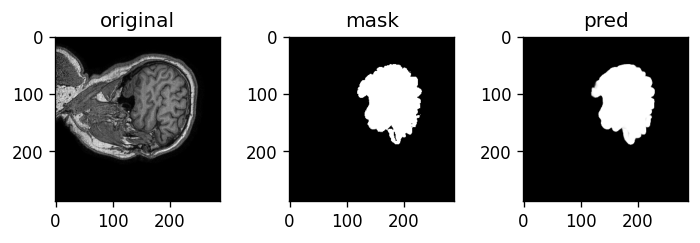

Test| Batch: 410 | Combined Loss: 0.015627684071660042 | BCE 0.0077604069374501705 | dice_loss 0.007867276668548584
Test| Batch: 420 | Combined Loss: 0.023588133975863457 | BCE 0.013256682083010674 | dice_loss 0.010331451892852783
Test| Batch: 430 | Combined Loss: 0.018410108983516693 | BCE 0.00799854937940836 | dice_loss 0.010411560535430908
Test| Batch: 440 | Combined Loss: 0.01968231238424778 | BCE 0.010118389502167702 | dice_loss 0.009563922882080078
Test| Batch: 450 | Combined Loss: 0.016100183129310608 | BCE 0.006636336445808411 | dice_loss 0.009463846683502197
Test| Batch: 460 | Combined Loss: 0.018131576478481293 | BCE 0.008764944039285183 | dice_loss 0.009366631507873535
Test| Batch: 470 | Combined Loss: 0.02078140527009964 | BCE 0.011072881519794464 | dice_loss 0.009708523750305176
Test| Batch: 480 | Combined Loss: 0.03140375763177872 | BCE 0.01799473725259304 | dice_loss 0.013409018516540527


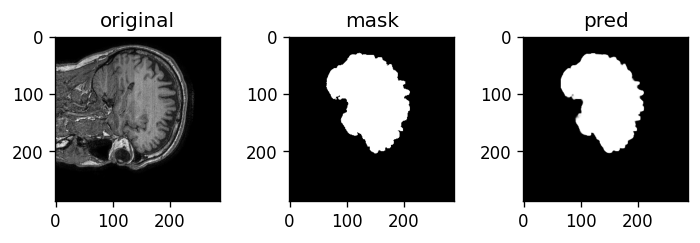

Test| Batch: 490 | Combined Loss: 0.026761338114738464 | BCE 0.014879688620567322 | dice_loss 0.011881649494171143
Test| Batch: 500 | Combined Loss: 0.025477977469563484 | BCE 0.01373419351875782 | dice_loss 0.011743783950805664
Test| Batch: 510 | Combined Loss: 0.016887351870536804 | BCE 0.008397622965276241 | dice_loss 0.008489727973937988
Test| Batch: 520 | Combined Loss: 0.018988069146871567 | BCE 0.009639198891818523 | dice_loss 0.009348869323730469
Test| Batch: 530 | Combined Loss: 0.01739494875073433 | BCE 0.008683194406330585 | dice_loss 0.008711755275726318
Test| Batch: 540 | Combined Loss: 0.024895289912819862 | BCE 0.01414654590189457 | dice_loss 0.010748744010925293
Test| Batch: 550 | Combined Loss: 0.18532486259937286 | BCE 0.12578363716602325 | dice_loss 0.05954122543334961
Test| Batch: 560 | Combined Loss: 0.5802175998687744 | BCE 0.4128076136112213 | dice_loss 0.1674100160598755


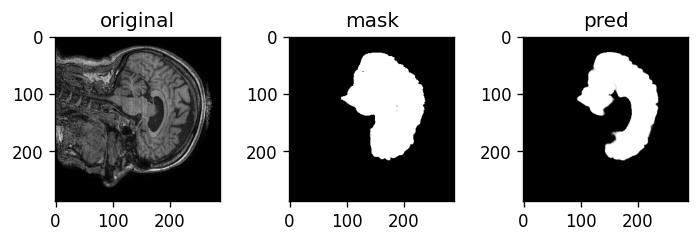

Test| Batch: 570 | Combined Loss: 0.09953834116458893 | BCE 0.05942680314183235 | dice_loss 0.040111541748046875
Average combined loss  --> 0.1249480032226226
Average BCE loss  --> 0.028315173634382518
Average dice loss  --> 0.0966328296603428


In [ ]:
path = '/content/gdrive/MyDrive/Philips/'
domain = 'philips'
ptype = '15'

data = ScanDataset(path, domain, ptype)

print('len:',len(data))

print('dev:',device)

data_loader = torch.utils.data.DataLoader(dataset = data, batch_size = batch_size, shuffle = False ,num_workers = 0)
loss = DiceBCELoss()

loss_hist, BCE_loss_hist, dice_loss_hist = test(model, data_loader, loss, domain, ptype, device)
print("Average combined loss  -->", mean(loss_hist))
print("Average BCE loss  -->", mean(BCE_loss_hist))
print("Average dice loss  -->", mean(dice_loss_hist))

# Test on Siemens

## Siemens 3


len: 13440
dev: cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test| Batch: 0 | Combined Loss: 0.9967999458312988 | BCE 0.0002196196001023054 | dice_loss 0.9965803027153015


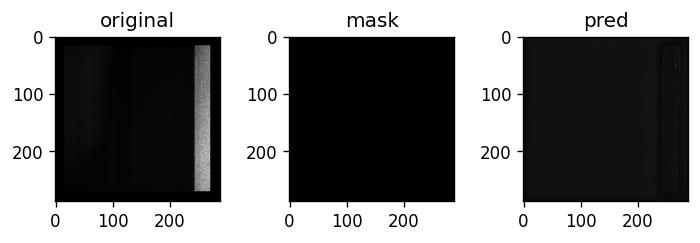

Test| Batch: 10 | Combined Loss: 0.25099673867225647 | BCE 0.0006435788818635046 | dice_loss 0.2503531575202942
Test| Batch: 20 | Combined Loss: 0.0301203690469265 | BCE 0.01545375119894743 | dice_loss 0.014666616916656494
Test| Batch: 30 | Combined Loss: 0.9967899322509766 | BCE 0.00021901450236327946 | dice_loss 0.9965709447860718
Test| Batch: 40 | Combined Loss: 0.9967851042747498 | BCE 0.0002187214995501563 | dice_loss 0.9965663552284241
Test| Batch: 50 | Combined Loss: 0.023034237325191498 | BCE 0.011770747601985931 | dice_loss 0.011263489723205566
Test| Batch: 60 | Combined Loss: 0.12202790379524231 | BCE 0.056421373039484024 | dice_loss 0.06560653448104858
Test| Batch: 70 | Combined Loss: 0.9968040585517883 | BCE 0.00021986787032801658 | dice_loss 0.9965841770172119
Test| Batch: 80 | Combined Loss: 0.39838725328445435 | BCE 0.02123655006289482 | dice_loss 0.3771507143974304


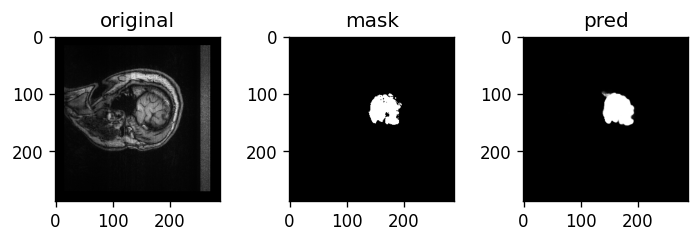

Test| Batch: 90 | Combined Loss: 0.025885343551635742 | BCE 0.013172685168683529 | dice_loss 0.012712657451629639
Test| Batch: 100 | Combined Loss: 0.9967969655990601 | BCE 0.00021943656611256301 | dice_loss 0.9965775012969971
Test| Batch: 110 | Combined Loss: 0.9967978596687317 | BCE 0.00021949307119939476 | dice_loss 0.9965783953666687
Test| Batch: 120 | Combined Loss: 0.018475327640771866 | BCE 0.008604500442743301 | dice_loss 0.009870827198028564
Test| Batch: 130 | Combined Loss: 0.047435857355594635 | BCE 0.014529803767800331 | dice_loss 0.03290605545043945
Test| Batch: 140 | Combined Loss: 0.9967858791351318 | BCE 0.00021877195104025304 | dice_loss 0.9965671300888062
Test| Batch: 150 | Combined Loss: 0.4962692856788635 | BCE 0.0006178109324537218 | dice_loss 0.4956514835357666
Test| Batch: 160 | Combined Loss: 0.027766268700361252 | BCE 0.013624888844788074 | dice_loss 0.014141380786895752


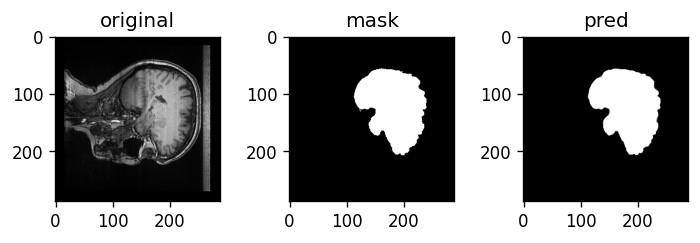

Test| Batch: 170 | Combined Loss: 0.9967992901802063 | BCE 0.00021958026627544314 | dice_loss 0.9965797066688538
Test| Batch: 180 | Combined Loss: 0.9967985153198242 | BCE 0.00021953195391688496 | dice_loss 0.9965789914131165
Test| Batch: 190 | Combined Loss: 0.019862212240695953 | BCE 0.008750475011765957 | dice_loss 0.011111736297607422
Test| Batch: 200 | Combined Loss: 0.060049332678318024 | BCE 0.022497152909636497 | dice_loss 0.03755217790603638
Test| Batch: 210 | Combined Loss: 0.9968028664588928 | BCE 0.00021979573648422956 | dice_loss 0.9965830445289612
Test| Batch: 220 | Combined Loss: 0.9974289536476135 | BCE 0.00048753476585261524 | dice_loss 0.9969414472579956
Test| Batch: 230 | Combined Loss: 0.028782401233911514 | BCE 0.015457067638635635 | dice_loss 0.013325333595275879
Test| Batch: 240 | Combined Loss: 0.9968001842498779 | BCE 0.00021963415201753378 | dice_loss 0.9965805411338806


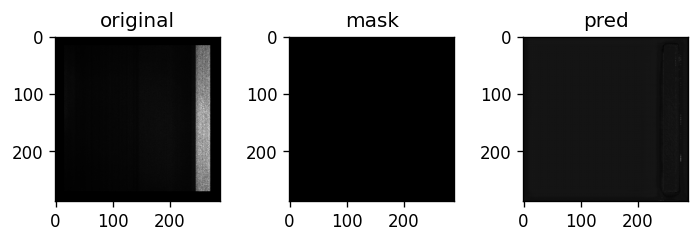

Test| Batch: 250 | Combined Loss: 0.9967993497848511 | BCE 0.00021958505385555327 | dice_loss 0.9965797662734985
Test| Batch: 260 | Combined Loss: 0.01565038599073887 | BCE 0.006377810146659613 | dice_loss 0.009272575378417969
Test| Batch: 270 | Combined Loss: 0.03551650419831276 | BCE 0.008396569639444351 | dice_loss 0.027119934558868408
Test| Batch: 280 | Combined Loss: 0.9967979788780212 | BCE 0.00021949819347355515 | dice_loss 0.9965784549713135
Test| Batch: 290 | Combined Loss: 0.4291971027851105 | BCE 0.0023794372100383043 | dice_loss 0.4268176555633545
Test| Batch: 300 | Combined Loss: 0.030475731939077377 | BCE 0.015548343770205975 | dice_loss 0.014927387237548828
Test| Batch: 310 | Combined Loss: 0.9967926144599915 | BCE 0.00021917511185165495 | dice_loss 0.9965734481811523
Test| Batch: 320 | Combined Loss: 0.9967846274375916 | BCE 0.0002186945202993229 | dice_loss 0.9965659379959106


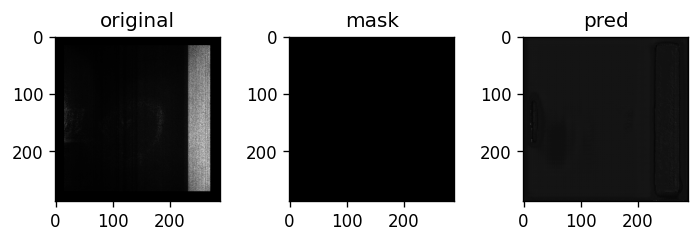

Test| Batch: 330 | Combined Loss: 0.01773061230778694 | BCE 0.007762092165648937 | dice_loss 0.00996851921081543
Test| Batch: 340 | Combined Loss: 0.04202578589320183 | BCE 0.014084618538618088 | dice_loss 0.02794116735458374
Test| Batch: 350 | Combined Loss: 0.9968000054359436 | BCE 0.00021962265600450337 | dice_loss 0.9965803623199463
Test| Batch: 360 | Combined Loss: 0.996792733669281 | BCE 0.00021918585116509348 | dice_loss 0.9965735673904419
Test| Batch: 370 | Combined Loss: 0.03524082154035568 | BCE 0.020319992676377296 | dice_loss 0.014920830726623535
Test| Batch: 380 | Combined Loss: 0.9967945218086243 | BCE 0.00021929139620624483 | dice_loss 0.9965752363204956
Test| Batch: 390 | Combined Loss: 0.9968014359474182 | BCE 0.00021970905072521418 | dice_loss 0.9965817332267761
Test| Batch: 400 | Combined Loss: 0.01742374151945114 | BCE 0.007877579890191555 | dice_loss 0.009546160697937012


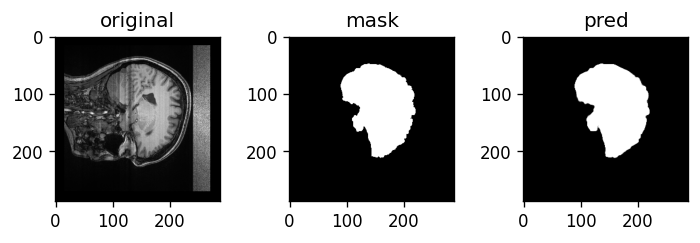

Test| Batch: 410 | Combined Loss: 0.053632356226444244 | BCE 0.020310143008828163 | dice_loss 0.03332221508026123
Test| Batch: 420 | Combined Loss: 0.9967986941337585 | BCE 0.000219544701394625 | dice_loss 0.9965791702270508
Test| Batch: 430 | Combined Loss: 0.10068778693675995 | BCE 0.001860961550846696 | dice_loss 0.0988268256187439
Test| Batch: 440 | Combined Loss: 0.037897102534770966 | BCE 0.019905438646674156 | dice_loss 0.01799166202545166
Test| Batch: 450 | Combined Loss: 0.9967938661575317 | BCE 0.00021925350301899016 | dice_loss 0.9965746402740479
Test| Batch: 460 | Combined Loss: 0.9967896342277527 | BCE 0.00021899855346418917 | dice_loss 0.9965706467628479
Test| Batch: 470 | Combined Loss: 0.021149028092622757 | BCE 0.010731148533523083 | dice_loss 0.0104178786277771
Test| Batch: 480 | Combined Loss: 0.07986851036548615 | BCE 0.033308517187833786 | dice_loss 0.04655998945236206


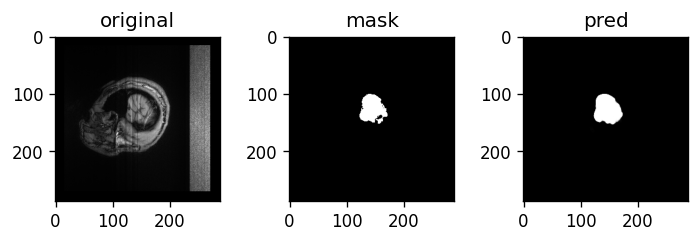

Test| Batch: 490 | Combined Loss: 0.9968012571334839 | BCE 0.00021969733643345535 | dice_loss 0.9965815544128418
Test| Batch: 500 | Combined Loss: 0.13924835622310638 | BCE 0.006023385562002659 | dice_loss 0.1332249641418457
Test| Batch: 510 | Combined Loss: 0.03497902303934097 | BCE 0.020036078989505768 | dice_loss 0.014942944049835205
Test| Batch: 520 | Combined Loss: 0.996801495552063 | BCE 0.00021971559908706695 | dice_loss 0.9965817928314209
Test| Batch: 530 | Combined Loss: 0.9967997074127197 | BCE 0.00021960760932415724 | dice_loss 0.9965801239013672
Test| Batch: 540 | Combined Loss: 0.037453874945640564 | BCE 0.020859820768237114 | dice_loss 0.0165940523147583
Test| Batch: 550 | Combined Loss: 0.08456738293170929 | BCE 0.024308275431394577 | dice_loss 0.060259103775024414
Test| Batch: 560 | Combined Loss: 0.996793806552887 | BCE 0.00021924950124230236 | dice_loss 0.9965745806694031


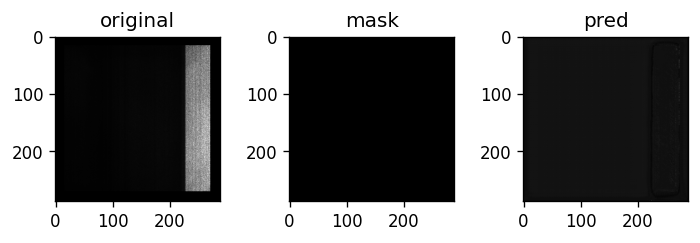

Test| Batch: 570 | Combined Loss: 0.9006633758544922 | BCE 0.043978217989206314 | dice_loss 0.8566851615905762
Test| Batch: 580 | Combined Loss: 0.02394382655620575 | BCE 0.01195512805134058 | dice_loss 0.011988699436187744
Test| Batch: 590 | Combined Loss: 0.9968018531799316 | BCE 0.0002197329595219344 | dice_loss 0.9965820908546448
Test| Batch: 600 | Combined Loss: 0.9968013763427734 | BCE 0.00021970615489408374 | dice_loss 0.9965816736221313
Test| Batch: 610 | Combined Loss: 0.033127669245004654 | BCE 0.018847111612558365 | dice_loss 0.014280557632446289
Test| Batch: 620 | Combined Loss: 0.034975290298461914 | BCE 0.011920036748051643 | dice_loss 0.02305525541305542
Test| Batch: 630 | Combined Loss: 0.9967913031578064 | BCE 0.00021909784118179232 | dice_loss 0.9965721964836121
Test| Batch: 640 | Combined Loss: 0.5152583122253418 | BCE 0.004470938351005316 | dice_loss 0.5107873678207397


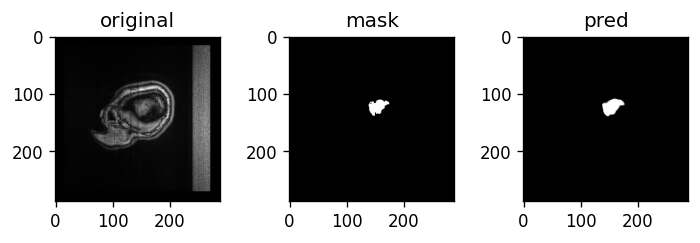

Test| Batch: 650 | Combined Loss: 0.027764569967985153 | BCE 0.013562572188675404 | dice_loss 0.014201998710632324
Test| Batch: 660 | Combined Loss: 0.9968017935752869 | BCE 0.00021973189723212272 | dice_loss 0.9965820908546448
Test| Batch: 670 | Combined Loss: 0.9967973232269287 | BCE 0.00021946038759779185 | dice_loss 0.9965778589248657
Test| Batch: 680 | Combined Loss: 0.02932804450392723 | BCE 0.01587485894560814 | dice_loss 0.013453185558319092
Test| Batch: 690 | Combined Loss: 0.04294905439019203 | BCE 0.01311633363366127 | dice_loss 0.02983272075653076
Test| Batch: 700 | Combined Loss: 0.9967983961105347 | BCE 0.00021952683164272457 | dice_loss 0.9965788722038269
Test| Batch: 710 | Combined Loss: 0.39202338457107544 | BCE 0.02141040563583374 | dice_loss 0.3706129789352417
Test| Batch: 720 | Combined Loss: 0.02590888738632202 | BCE 0.014274059794843197 | dice_loss 0.01163482666015625


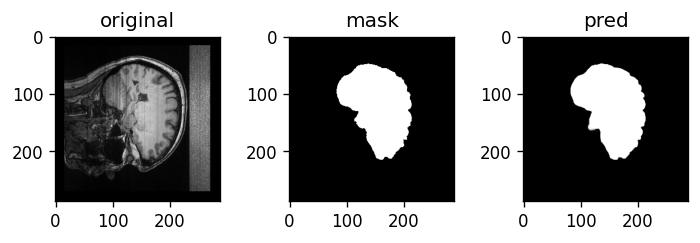

Test| Batch: 730 | Combined Loss: 0.9968022108078003 | BCE 0.0002197555877501145 | dice_loss 0.9965824484825134
Test| Batch: 740 | Combined Loss: 0.9968019127845764 | BCE 0.00021973514230921865 | dice_loss 0.9965821504592896
Test| Batch: 750 | Combined Loss: 0.03290269896388054 | BCE 0.01831863448023796 | dice_loss 0.014584064483642578
Test| Batch: 760 | Combined Loss: 0.06430418789386749 | BCE 0.015077246353030205 | dice_loss 0.04922693967819214
Test| Batch: 770 | Combined Loss: 0.9967974424362183 | BCE 0.00021946823108009994 | dice_loss 0.9965779781341553
Test| Batch: 780 | Combined Loss: 0.15683439373970032 | BCE 0.0030132897663861513 | dice_loss 0.15382111072540283
Test| Batch: 790 | Combined Loss: 0.04339271038770676 | BCE 0.02391611784696579 | dice_loss 0.019476592540740967
Test| Batch: 800 | Combined Loss: 0.9968032240867615 | BCE 0.00021981705504003912 | dice_loss 0.9965834021568298


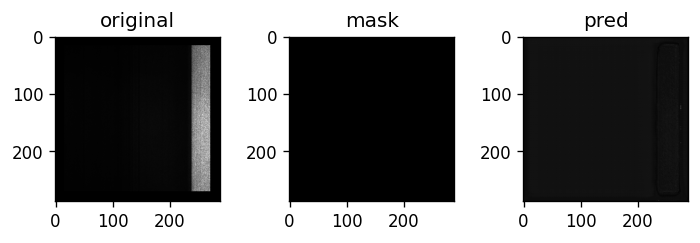

Test| Batch: 810 | Combined Loss: 0.9968010783195496 | BCE 0.00021968717919662595 | dice_loss 0.9965813755989075
Test| Batch: 820 | Combined Loss: 0.021208543330430984 | BCE 0.009939093142747879 | dice_loss 0.011269450187683105
Test| Batch: 830 | Combined Loss: 0.03321043774485588 | BCE 0.011200706474483013 | dice_loss 0.022009730339050293
Average combined loss  --> 0.5051182693890518
Average BCE loss  --> 0.007907480837422468
Average dice loss  --> 0.4972107890106383


In [ ]:
path = '/content/gdrive/MyDrive/Siemens3/'
domain = 'siemens'
ptype = '3'

data = ScanDataset(path, domain, ptype)

print('len:',len(data))

print('dev:',device)

data_loader = torch.utils.data.DataLoader(dataset = data, batch_size = batch_size, shuffle = False ,num_workers = 0)
loss = DiceBCELoss()

loss_hist, BCE_loss_hist, dice_loss_hist = test(model, data_loader, loss, domain, ptype, device)
print("Average combined loss  -->", mean(loss_hist))
print("Average BCE loss  -->", mean(BCE_loss_hist))
print("Average dice loss  -->", mean(dice_loss_hist))

## Siemens 15

len: 11520
dev: cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test| Batch: 0 | Combined Loss: 0.9967667460441589 | BCE 0.00021762594406027347 | dice_loss 0.996549129486084


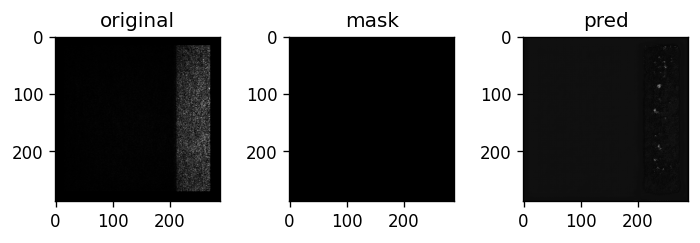

Test| Batch: 10 | Combined Loss: 0.3195783197879791 | BCE 0.0022576868068426847 | dice_loss 0.31732064485549927
Test| Batch: 20 | Combined Loss: 0.07923732697963715 | BCE 0.042612116783857346 | dice_loss 0.0366252064704895
Test| Batch: 30 | Combined Loss: 0.04453432559967041 | BCE 0.023046791553497314 | dice_loss 0.021487534046173096
Test| Batch: 40 | Combined Loss: 0.025093868374824524 | BCE 0.012202695943415165 | dice_loss 0.012891173362731934
Test| Batch: 50 | Combined Loss: 0.0912272185087204 | BCE 0.027524875476956367 | dice_loss 0.06370234489440918
Test| Batch: 60 | Combined Loss: 0.9967774152755737 | BCE 0.0002182637545047328 | dice_loss 0.9965591430664062
Test| Batch: 70 | Combined Loss: 0.26162266731262207 | BCE 0.0018610391998663545 | dice_loss 0.25976163148880005
Test| Batch: 80 | Combined Loss: 0.04543093219399452 | BCE 0.01894352212548256 | dice_loss 0.026487410068511963


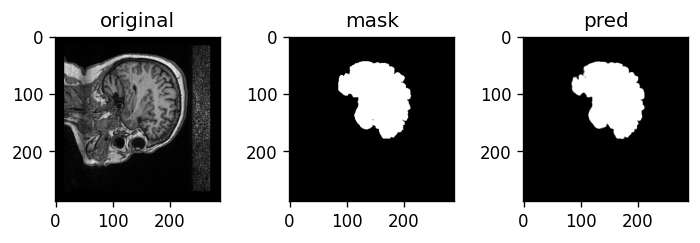

Test| Batch: 90 | Combined Loss: 0.040096282958984375 | BCE 0.02045685052871704 | dice_loss 0.019639432430267334
Test| Batch: 100 | Combined Loss: 0.02324077859520912 | BCE 0.01113048568367958 | dice_loss 0.012110292911529541
Test| Batch: 110 | Combined Loss: 0.05694906786084175 | BCE 0.01452945452183485 | dice_loss 0.042419612407684326
Test| Batch: 120 | Combined Loss: 0.9967591762542725 | BCE 0.0002171746309613809 | dice_loss 0.9965419769287109
Test| Batch: 130 | Combined Loss: 0.13894176483154297 | BCE 0.0015928152715787292 | dice_loss 0.1373489499092102
Test| Batch: 140 | Combined Loss: 0.024379055947065353 | BCE 0.011752945370972157 | dice_loss 0.012626111507415771
Test| Batch: 150 | Combined Loss: 0.10585892200469971 | BCE 0.06267350912094116 | dice_loss 0.043185412883758545
Test| Batch: 160 | Combined Loss: 0.021158261224627495 | BCE 0.009369892999529839 | dice_loss 0.011788368225097656


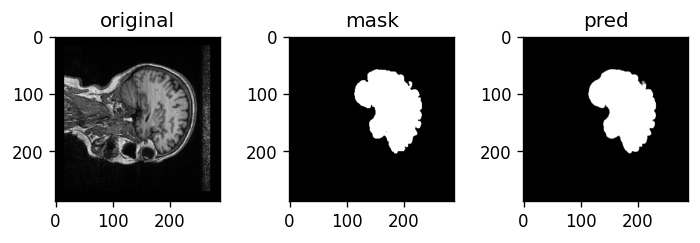

Test| Batch: 170 | Combined Loss: 0.057764191180467606 | BCE 0.007926900871098042 | dice_loss 0.04983729124069214
Test| Batch: 180 | Combined Loss: 0.9967818260192871 | BCE 0.00021852806094102561 | dice_loss 0.9965633153915405
Test| Batch: 190 | Combined Loss: 0.3827801048755646 | BCE 0.016600685194134712 | dice_loss 0.3661794066429138
Test| Batch: 200 | Combined Loss: 0.02222997136414051 | BCE 0.008020283654332161 | dice_loss 0.01420968770980835
Test| Batch: 210 | Combined Loss: 0.2605412006378174 | BCE 0.15729986131191254 | dice_loss 0.10324132442474365
Test| Batch: 220 | Combined Loss: 0.023154519498348236 | BCE 0.011323891580104828 | dice_loss 0.011830627918243408
Test| Batch: 230 | Combined Loss: 0.07292298972606659 | BCE 0.0190154779702425 | dice_loss 0.05390751361846924
Test| Batch: 240 | Combined Loss: 0.9970548152923584 | BCE 0.00024404106079600751 | dice_loss 0.996810793876648


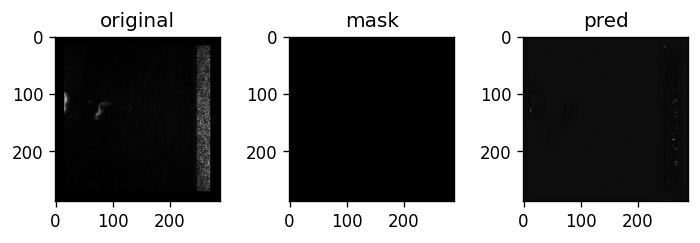

Test| Batch: 250 | Combined Loss: 0.16145190596580505 | BCE 0.004678336437791586 | dice_loss 0.15677356719970703
Test| Batch: 260 | Combined Loss: 0.029994022101163864 | BCE 0.013290057890117168 | dice_loss 0.01670396327972412
Test| Batch: 270 | Combined Loss: 0.372551828622818 | BCE 0.23991110920906067 | dice_loss 0.13264071941375732
Test| Batch: 280 | Combined Loss: 0.01460533682256937 | BCE 0.006021195091307163 | dice_loss 0.008584141731262207
Test| Batch: 290 | Combined Loss: 0.07292639464139938 | BCE 0.019773712381720543 | dice_loss 0.05315268039703369
Test| Batch: 300 | Combined Loss: 0.99677973985672 | BCE 0.0002184048789786175 | dice_loss 0.9965613484382629
Test| Batch: 310 | Combined Loss: 0.2857477068901062 | BCE 0.00295346905477345 | dice_loss 0.2827942371368408
Test| Batch: 320 | Combined Loss: 0.020210590213537216 | BCE 0.008327151648700237 | dice_loss 0.011883437633514404


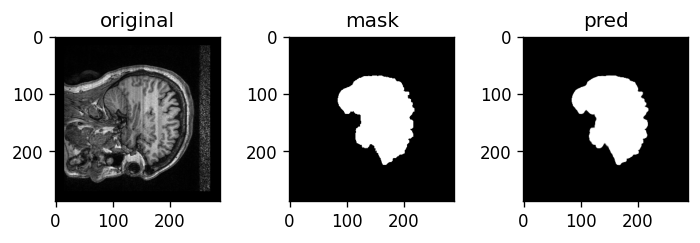

Test| Batch: 330 | Combined Loss: 0.048091087490320206 | BCE 0.026942703872919083 | dice_loss 0.021148383617401123
Test| Batch: 340 | Combined Loss: 0.015606159344315529 | BCE 0.006719762925058603 | dice_loss 0.008886396884918213
Test| Batch: 350 | Combined Loss: 0.06063152849674225 | BCE 0.015918685123324394 | dice_loss 0.044712841510772705
Test| Batch: 360 | Combined Loss: 0.9967981576919556 | BCE 0.00021951475355308503 | dice_loss 0.9965786337852478
Test| Batch: 370 | Combined Loss: 0.18886665999889374 | BCE 0.0050909328274428844 | dice_loss 0.18377572298049927
Test| Batch: 380 | Combined Loss: 0.0751820057630539 | BCE 0.03856514021754265 | dice_loss 0.03661686182022095
Test| Batch: 390 | Combined Loss: 0.3444123864173889 | BCE 0.23687678575515747 | dice_loss 0.10753560066223145
Test| Batch: 400 | Combined Loss: 0.016077160835266113 | BCE 0.00697171688079834 | dice_loss 0.009105443954467773


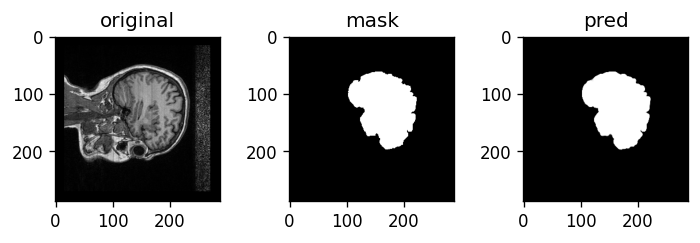

Test| Batch: 410 | Combined Loss: 0.0785282552242279 | BCE 0.018732817843556404 | dice_loss 0.05979543924331665
Test| Batch: 420 | Combined Loss: 0.9967785477638245 | BCE 0.00021833200298715383 | dice_loss 0.9965602159500122
Test| Batch: 430 | Combined Loss: 0.9967603087425232 | BCE 0.00021724411635659635 | dice_loss 0.9965430498123169
Test| Batch: 440 | Combined Loss: 0.033556096255779266 | BCE 0.015980713069438934 | dice_loss 0.017575383186340332
Test| Batch: 450 | Combined Loss: 0.025591719895601273 | BCE 0.012888836674392223 | dice_loss 0.012702882289886475
Test| Batch: 460 | Combined Loss: 0.023845670744776726 | BCE 0.011408446356654167 | dice_loss 0.012437224388122559
Test| Batch: 470 | Combined Loss: 0.33953577280044556 | BCE 0.07158880680799484 | dice_loss 0.2679469585418701
Test| Batch: 480 | Combined Loss: 0.9967693090438843 | BCE 0.00021777689107693732 | dice_loss 0.996551513671875


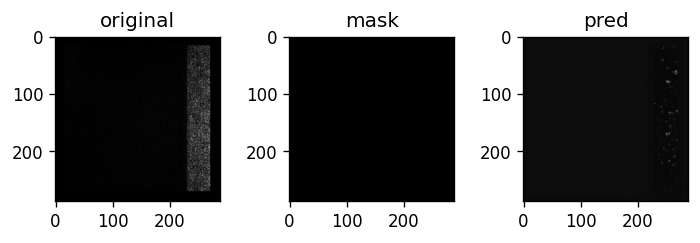

Test| Batch: 490 | Combined Loss: 0.36485904455184937 | BCE 0.001343593350611627 | dice_loss 0.3635154366493225
Test| Batch: 500 | Combined Loss: 0.026794586330652237 | BCE 0.009898457676172256 | dice_loss 0.01689612865447998
Test| Batch: 510 | Combined Loss: 0.05019008368253708 | BCE 0.02721267379820347 | dice_loss 0.02297741174697876
Test| Batch: 520 | Combined Loss: 0.2984415888786316 | BCE 0.20025195181369781 | dice_loss 0.09818965196609497
Test| Batch: 530 | Combined Loss: 0.07192911207675934 | BCE 0.023321527987718582 | dice_loss 0.048607587814331055
Test| Batch: 540 | Combined Loss: 0.9967969059944153 | BCE 0.00021943528554402292 | dice_loss 0.9965774416923523
Test| Batch: 550 | Combined Loss: 0.27977219223976135 | BCE 0.004594837781041861 | dice_loss 0.27517735958099365
Test| Batch: 560 | Combined Loss: 0.03107871301472187 | BCE 0.013076858595013618 | dice_loss 0.018001854419708252


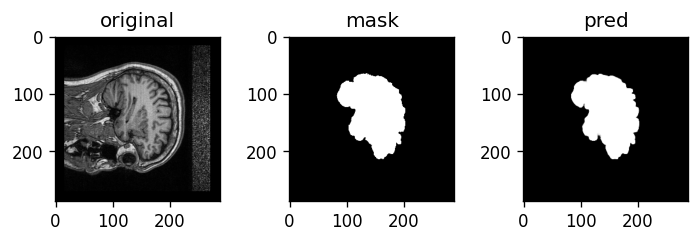

Test| Batch: 570 | Combined Loss: 0.033217109739780426 | BCE 0.01635119877755642 | dice_loss 0.016865909099578857
Test| Batch: 580 | Combined Loss: 0.019963234663009644 | BCE 0.009715707041323185 | dice_loss 0.010247528553009033
Test| Batch: 590 | Combined Loss: 0.07934390008449554 | BCE 0.018341105431318283 | dice_loss 0.06100279092788696
Test| Batch: 600 | Combined Loss: 0.9967807531356812 | BCE 0.00021846465824637562 | dice_loss 0.9965623021125793
Test| Batch: 610 | Combined Loss: 0.4537404477596283 | BCE 0.0018875233363360167 | dice_loss 0.4518529176712036
Test| Batch: 620 | Combined Loss: 0.023938696831464767 | BCE 0.010226706974208355 | dice_loss 0.013711988925933838
Test| Batch: 630 | Combined Loss: 0.074133962392807 | BCE 0.042618900537490845 | dice_loss 0.03151506185531616
Test| Batch: 640 | Combined Loss: 0.020584236830472946 | BCE 0.010019195266067982 | dice_loss 0.010565042495727539


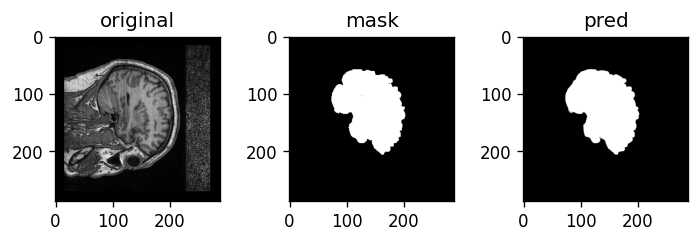

Test| Batch: 650 | Combined Loss: 0.06102621555328369 | BCE 0.023509683087468147 | dice_loss 0.03751653432846069
Test| Batch: 660 | Combined Loss: 0.9967893958091736 | BCE 0.00021898484556004405 | dice_loss 0.9965704083442688
Test| Batch: 670 | Combined Loss: 0.1858721524477005 | BCE 0.006589903030544519 | dice_loss 0.17928224802017212
Test| Batch: 680 | Combined Loss: 0.036438655108213425 | BCE 0.017030905932188034 | dice_loss 0.01940774917602539
Test| Batch: 690 | Combined Loss: 0.09146413207054138 | BCE 0.05749490484595299 | dice_loss 0.033969223499298096
Test| Batch: 700 | Combined Loss: 0.015738187357783318 | BCE 0.007009147200733423 | dice_loss 0.008729040622711182
Test| Batch: 710 | Combined Loss: 0.09924136102199554 | BCE 0.024713439866900444 | dice_loss 0.07452791929244995
Average combined loss  --> 0.2879625261748313
Average BCE loss  --> 0.028177849026623233
Average dice loss  --> 0.2597846771279971


In [ ]:
path = '/content/gdrive/MyDrive/Siemens15/'
domain = 'siemens'
ptype = '15'

data = ScanDataset(path, domain, ptype)

print('len:',len(data))

print('dev:',device)

data_loader = torch.utils.data.DataLoader(dataset = data, batch_size = batch_size, shuffle = False ,num_workers = 0)
loss = DiceBCELoss()

loss_hist, BCE_loss_hist, dice_loss_hist = test(model, data_loader, loss, domain, ptype, device)
print("Average combined loss  -->", mean(loss_hist))
print("Average BCE loss  -->", mean(BCE_loss_hist))
print("Average dice loss  -->", mean(dice_loss_hist))